In [1]:

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## 데이터 읽어오기.
raw_df = pd.read_csv("../dataset/BostonHousing.csv")

print(raw_df.info())
print(raw_df.head())


1 Physical GPUs, 1 Logical GPUs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  

In [2]:

dataset=raw_df.copy()
label_data=dataset.pop("MEDV")

dataset_stats = dataset.describe()
#dataset_stats.pop("MEDV")
dataset_stats = dataset_stats.transpose()



def min_max_norm(x):
  return (x - dataset_stats['min']) / ( dataset_stats['max'] - dataset_stats['min'] )

def standard_norm(x):
  return (x - dataset_stats['mean']) / (dataset_stats["std"])

normed_train_data = standard_norm(dataset)#min_max_norm(dataset)



In [3]:


# 모델의 설정
input_Layer = tf.keras.layers.Input(shape=(13,))
x = tf.keras.layers.Dense(120, activation='sigmoid')(input_Layer)
x= tf.keras.layers.Dense(100, activation='sigmoid')(x)
x= tf.keras.layers.Dense(100, activation='sigmoid')(x)
Out_Layer= tf.keras.layers.Dense(1, activation=None)(x)

model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense (Dense)                (None, 120)               1680      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 23,981
Trainable params: 23,981
Non-trainable params: 0
_________________________________________________________________


In [4]:


## regression이므로 평가 지표는 MSE가 된다.
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

result=model.fit(normed_train_data, label_data, epochs=2000, batch_size=100)
## model fit은 histoy를 반환한다. 훈련중의 발생하는 모든 정보를 담고 있는 딕셔너리.
## histoy는 딕셔너리이므로 keys()를 통해 출력의 key(카테고리)를 알 수 있다.
print(result.history.keys())


Epoch 1/2000
6/6 [==============================] - 1s 3ms/step - loss: 262.2863 - root_mean_squared_error: 16.1953
Epoch 2/2000
6/6 [==============================] - 0s 2ms/step - loss: 85.5297 - root_mean_squared_error: 9.2482
Epoch 3/2000
6/6 [==============================] - 0s 3ms/step - loss: 85.0304 - root_mean_squared_error: 9.2212
Epoch 4/2000
6/6 [==============================] - 0s 3ms/step - loss: 85.8681 - root_mean_squared_error: 9.2665
Epoch 5/2000
6/6 [==============================] - 0s 3ms/step - loss: 83.9604 - root_mean_squared_error: 9.1630
Epoch 6/2000
6/6 [==============================] - 0s 2ms/step - loss: 82.9121 - root_mean_squared_error: 9.1056
Epoch 7/2000
6/6 [==============================] - 0s 2ms/step - loss: 83.4480 - root_mean_squared_error: 9.1350
Epoch 8/2000
6/6 [==============================] - 0s 3ms/step - loss: 82.2147 - root_mean_squared_error: 9.0672
Epoch 9/2000
6/6 [==============================] - 0s 3ms/step - loss: 81.9838 - root

16/16 [==============================] - 0s 1ms/step - loss: 5.5530 - root_mean_squared_error: 2.3565

 Test rmse: 2.3565


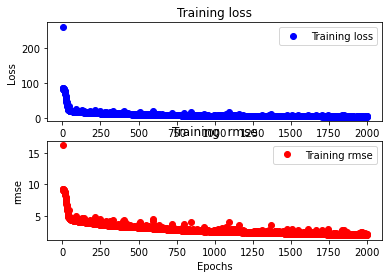

In [5]:

### history에서 loss와 val_loss의 key를 가지는 값들만 추출
loss = result.history['loss']
### loss와 val_loss를 그래프화
epochs = range(1, len(loss) + 1)
plt.subplot(211)  ## 2x1 개의 그래프 중에 1번째
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### history에서 root_mean_squared_error 가지는 값들만 추출
rmse = result.history['root_mean_squared_error']
epochs = range(1, len(rmse) + 1)
### mean_absolute_error 그래프화
plt.subplot(212)  ## 2x1 개의 그래프 중에 2번째
plt.plot(epochs, rmse, 'ro', label='Training rmse')
plt.title('Training  rmse')
plt.xlabel('Epochs')
plt.ylabel('rmse')
plt.legend()

print("\n Test rmse: %.4f" % (model.evaluate(normed_train_data, label_data)[1]))

plt.show()